In [70]:
import numpy as np
import torch
from torch import tensor
import matplotlib.pyplot as plt, seaborn as sns
sns.set()
torch.set_printoptions(precision=3, linewidth=100)

In [58]:
def f(x): return x**3 - 2*x**2 + 1
x = torch.linspace(-5, 5, 1000)
y = torch.tensor(list(map(f, x)))

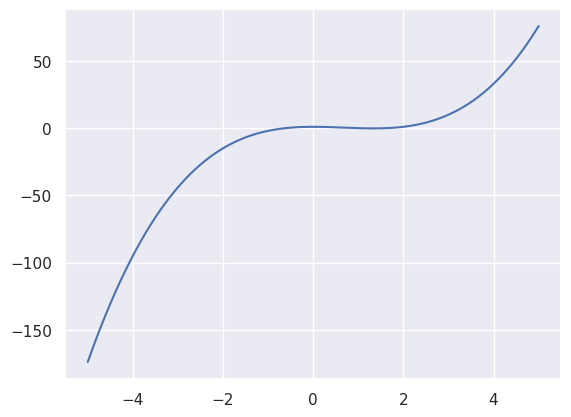

In [59]:
plt.plot(x, y)

In [60]:
x = x[:, None]; y = y[:, None]

<br><br> **NN arch** <br>
1 → 50 → 1

In [46]:
class Lin():
    def __init__(self, w, b):
        self.w = w; self.b = b;
    def __call__(self, inp):
        self.inp = inp; self.out = inp@self.w + self.b
        return self.out
    def backward(self):
        self.w.grad = self.inp.T @ self.out.grad
        self.b.grad = self.out.grad.sum(dim=0)
        self.inp.grad = self.out.grad @ self.w.T

In [9]:
class Relu():
    def __call__(self, inp): 
        self.inp = inp; self.out = inp.clamp_min(0.); 
        return self.out
    def backward(self): self.inp.grad = (self.inp > 0).float() * self.out.grad

In [41]:
class MSE():
    def __call__(self, preds, target):
        self.inp = preds; self.targ = target; self.out = ((preds - target)**2).mean()
        return self.out
    def backward(self):
        self.inp.grad = 1/len(self.inp)*2*(self.inp - self.targ)

In [57]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss_func = MSE()
    def __call__(self, x, targ=None):
        for l in self.layers:
            x = l(x)
        if targ != None: self.loss = self.loss_func(x, targ)
        return x, self.loss
    def backward(self):
        self.loss_func.backward()
        for l in self.layers[::-1]:
            l.backward()

In [61]:
w1 = torch.randn(1, 50)
b1 = torch.randn(50)
w2 = torch.randn(50, 1)
b2 = torch.randn(1)

In [62]:
x.shape, y.shape

(torch.Size([200, 1]), torch.Size([1000]))

In [66]:
model = Model(w1, b1, w2, b2)
x = torch.randn(200, 1) * 5
res = model(x, y[:200, None])
model.backward()

<br>**Refactor 2**

In [4]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    def forward(self): raise Exception('not implemented')
    def bwd(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [35]:
class Lin(Module):
    def __init__(self, w, b): self.w = w; self.b = b;
    def forward(self, inp): return inp@self.w + self.b
    def bwd(self, out, inp):
        self.w.grad = inp.T @ self.out.grad
        self.b.grad = self.out.grad.sum(dim=0)
        inp.grad = self.out.grad @ self.w.T

In [50]:
class Relu(Module):
    def forward(self, inp): return inp.clamp_min(0.)
    def bwd(self, out, inp): inp.grad = (inp > 0).float() * self.out.grad

In [56]:
class MSE(Module):
    def forward(self, preds, target): return ((preds - target)**2).mean()
    def bwd(self, out, inp, targ):
        inp.grad = 1/len(inp)*2*(inp - targ)

In [80]:
class Model():
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Lin(w1, b1), Relu(), Lin(w2, b2)]
        self.loss_func = MSE()
    def __call__(self, x, targ=None):
        for l in self.layers:
            x = l(x)
        if targ != None: self.loss = self.loss_func(x, targ)
        return x, self.loss
    def backward(self):
        self.loss_func.backward()
        for l in self.layers[::-1]:
            l.backward()

In [78]:
w1 = torch.randn(1, 50)
b1 = torch.randn(50)
w2 = torch.randn(50, 1)
b2 = torch.randn(1)

x.shape, y.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

In [81]:
model = Model(w1, b1, w2, b2)
res = model(x, y)
model.backward()

<br>**using torch.nn**

In [73]:
import torch.nn as nn, torch.nn.functional as F

In [87]:
class Linear(nn.Module):
    def __init__(self, n_in, n_out): 
        super().__init__()
        self.w = torch.randn(n_in, n_out).requires_grad_(); self.b = torch.randn(n_out).requires_grad_();
    def forward(self, inp): return inp@self.w + self.b

In [103]:
class Model():
    def __init__(self):
        super().__init__()
        self.layers = [Linear(1, 50), Relu(), Linear(50, 1)]
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return F.mse_loss(x, targ)

In [104]:
x.shape, y.shape

(torch.Size([1000, 1]), torch.Size([1000, 1]))

In [105]:
model = Model()
loss = model(x, y)
loss.backward()

In [106]:
model.layers[0].w.grad

tensor([[   3.122, -154.041, -188.921,   47.119,  -93.958,   87.140,   -2.335,   92.087, -133.655,
           76.248,  -49.679,  336.974,   21.912,    0.000,  -14.866,  129.370,  135.460,  104.478,
         -533.433,    0.000,   65.569,  169.147,   54.352,  170.821,   78.420,  111.106,  -23.742,
           59.888, -401.476,   78.092,  -19.932,  -87.981,  -10.249,    0.000,    0.000,  107.757,
           22.597,  -98.173,  109.576,  -58.409,  -38.605,   13.738,    0.000, -210.019,   88.675,
         -154.275,  -46.664,  -56.900,  -15.529,    6.733]])